In [231]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier

In [248]:
train_data = train_data = pd.read_csv('data/preprocessed_dataset.csv')
train_data['increase_stock'] = np.where(train_data['increase_stock'] == 'low_bike_demand', 0, 1)
import pandas as pd
print(train_data.dtypes)

hour_of_day         int64
day_of_week         int64
month               int64
weekday             int64
summertime          int64
temp              float64
dew               float64
humidity          float64
snowdepth           int64
windspeed         float64
cloudcover        float64
visibility        float64
increase_stock      int64
day                 int64
rain                int64
dtype: object


In [253]:
categorical_features = ['weekday','month','summertime','day','rain','increase_stock']
#'hour_of_day', 'day_of_week' ? these make the performance worse as categorical values..
for feature in categorical_features:
    train_data[feature] = train_data[feature].astype('category')

# Check the updated data types
print(train_data.dtypes)


hour_of_day          int64
day_of_week          int64
month             category
weekday           category
summertime        category
temp               float64
dew                float64
humidity           float64
snowdepth            int64
windspeed          float64
cloudcover         float64
visibility         float64
increase_stock    category
day               category
rain              category
dtype: object


In [234]:
X = train_data.drop('increase_stock', axis=1)
y = train_data['increase_stock']

print(X.shape)
print(y.shape)

(1600, 14)
(1600,)


In [235]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [236]:
#train model
xgb_model = xgb.XGBClassifier(
    random_state=0,
    enable_categorical = True
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

In [237]:
#check performance 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f'Confusion Matrix: \n{conf_matrix}')

Accuracy: 0.88
Precision: 0.69
Recall: 0.66
F1-Score: 0.67
Confusion Matrix: 
[[245  17]
 [ 20  38]]


In [245]:
#find best hyper parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'n_estimators': [0, 25, 50, 100],
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=0, enable_categorical = True),
    param_grid=param_grid,
    scoring='recall',  # RECALL OR ????
    cv=3,  # 3fold
    verbose=1,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best recall:", grid_search.best_score_)


Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 25}
Best recall: 0.7086466165413534


In [250]:
final_model = xgb.XGBClassifier(**grid_search.best_params_, random_state=0, enable_categorical=True)

In [252]:
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f'Confusion Matrix: \n{conf_matrix}')

Accuracy: 0.88
Precision: 0.68
Recall: 0.59
F1-Score: 0.63
Confusion Matrix: 
[[246  16]
 [ 24  34]]


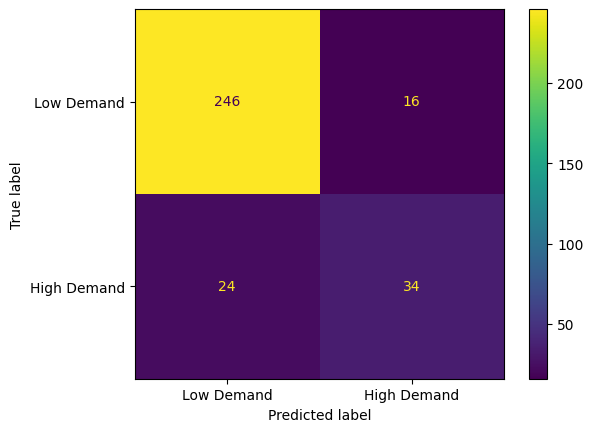

In [241]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Demand', 'High Demand'])
disp.plot()

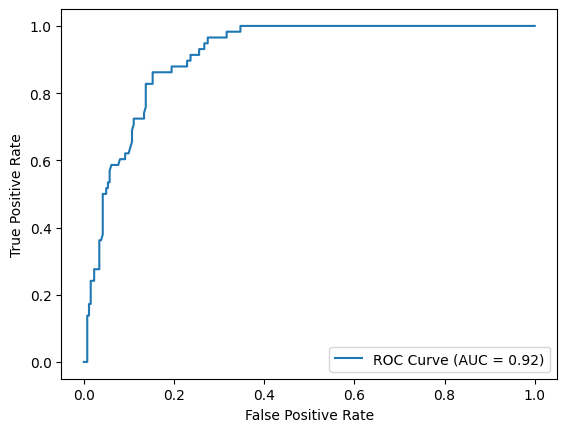

In [242]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_prob = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
